In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Setup device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠ GPU not available, using CPU")

PyTorch version: 2.6.0+cu124
Device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU Memory: 6.00 GB


## Fetch and clean data

In [3]:
import os
import glob
import pandas as pd
import numpy as np

# Define both directories
dirs = [
    # "../../data/afras/raw",
    "../../data/martin2/raw"
]

# Collect all CSV file paths
csv_files = []
for d in dirs:
    csv_files.extend(glob.glob(os.path.join(d, "integrated_data_*.csv")))

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(" -", f)

# Read and concatenate all files
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

print("="*60)
print("RAW DATA INFO (combined)")
print("="*60)
print(f"Total combined shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 3 rows:\n{df.head(3)}")

# Define numeric columns
numeric_columns = [
    'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3',
    'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky'
]

# Convert to numeric
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop corrupted rows
df_clean = df.dropna(subset=numeric_columns)

print(f"\nRows removed (corrupted/missing data): {len(df) - len(df_clean)}")
print(f"Clean data shape: {df_clean.shape}")

# Convert to numpy array
data = df_clean[numeric_columns].values.astype(np.float32)

print(f"\nFinal numeric data shape: {data.shape}")
print(f"Data statistics:\n{pd.DataFrame(data, columns=numeric_columns).describe()}")

Found 5 CSV files:
 - ../../data/martin2/raw\integrated_data_20251108_133856.csv
 - ../../data/martin2/raw\integrated_data_20251108_134236.csv
 - ../../data/martin2/raw\integrated_data_20251108_135628.csv
 - ../../data/martin2/raw\integrated_data_20251108_141913.csv
 - ../../data/martin2/raw\integrated_data_20251108_144714.csv
RAW DATA INFO (combined)
Total combined shape: (125945, 17)
Columns: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label']

First 3 rows:
                    timestamp iteration env0 raw0 env1 raw1 env2 raw2 env3  \
0  2025-11-08T13:57:24.034480         0   59  496  262  496  125  494   35   
1  2025-11-08T13:57:24.068311         1   55  494  271  492  112  494   35   
2  2025-11-08T13:57:24.100968         2   64  495  332  502  114  494   35   

  raw3  thumb_tip  thumb_base   index  middle    ring  pinky hand_label  
0  494     0.8690      0.8652  0

C:\Users\tobia\AppData\Local\Temp\ipykernel_6208\4020690967.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df_list, ignore_index=True)


In [4]:
sensor_columns = ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
finger_columns = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

sensor_indices = [numeric_columns.index(col) for col in sensor_columns]
finger_indices = [numeric_columns.index(col) for col in finger_columns]

print("="*60)
print("DATA CONFIGURATION")
print("="*60)
print(f"Sensor columns (inputs): {sensor_columns}")
print(f"Sensor indices: {sensor_indices}")
print(f"Number of input features: {len(sensor_indices)}")
print(f"\nFinger columns (outputs): {finger_columns}")
print(f"Finger indices: {finger_indices}")
print(f"Number of output features: {len(finger_indices)}")

DATA CONFIGURATION
Sensor columns (inputs): ['env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
Sensor indices: [1, 2, 3, 4, 5, 6, 7, 8]
Number of input features: 8

Finger columns (outputs): ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']
Finger indices: [9, 10, 11, 12, 13, 14]
Number of output features: 6


In [5]:
from scipy.signal import butter, lfilter

def highpass_causal(signal, fs, cutoff=0.5, order=4):
    """
    Causal high-pass filter using lfilter (matches streaming inference).
    This processes data sequentially without lookahead, suitable for real-time applications.
    """
    b, a = butter(order, cutoff / (0.5 * fs), btype='high')
    # lfilter is causal - only uses past/present data
    return lfilter(b, a, signal)

fs = 1.0/0.03446

print("Applying CAUSAL high-pass filter to env channels (matches streaming inference)...")
for col in ['env0', 'env1', 'env2', 'env3']:
    df_clean[col] = highpass_causal(df_clean[col].values, fs, cutoff=0.5)
print("✓ Causal filtering complete - model will now match streaming inference behavior!")


Applying CAUSAL high-pass filter to env channels (matches streaming inference)...
✓ Causal filtering complete - model will now match streaming inference behavior!

✓ Causal filtering complete - model will now match streaming inference behavior!


### 🔧 Filter Type Explanation

**Current Setup: CAUSAL filtering with `lfilter`**

- ✅ Processes data sequentially (sample-by-sample)
- ✅ Only uses past and present data (no lookahead)
- ✅ **Matches streaming inference behavior**
- ⚠️ Introduces phase shift
- Result: Model learns patterns it will actually see during deployment

**Previous Setup: NON-CAUSAL filtering with `filtfilt`**

- ❌ Processes entire dataset forward then backward
- ❌ Zero phase shift but uses future information
- ❌ **Does NOT match streaming inference**
- Result: Better offline metrics but fails in real-time deployment

**Why this matters:** When you trained with `filtfilt` but deployed with `lfilter`, the model saw different filtered patterns → R² dropped from 0.80 to -0.65!

In [6]:
X = df_clean[sensor_columns].values.astype(np.float32)
y = df_clean[finger_columns].values.astype(np.float32)

# Create scalers
scaler_X = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = y

print("="*60)
print("NORMALIZATION INFO")
print("="*60)
print("Input feature means (after scaling):", X_scaled.mean(axis=0))
print("Input feature stds (after scaling):", X_scaled.std(axis=0))

NORMALIZATION INFO
Input feature means (after scaling): [-3.5967709e-09 -2.6653966e-09  3.5513379e-09  2.6290502e-08
 -1.3629868e-10  5.6942562e-09  2.1050575e-09 -1.1221925e-08]
Input feature stds (after scaling): [1.         1.         1.         0.99999994 1.         1.
 1.         1.        ]


In [7]:
# save scalars for inference

import joblib

joblib.dump(scaler_X, "scaler_inputs_lstm.pkl")

['scaler_inputs_lstm.pkl']

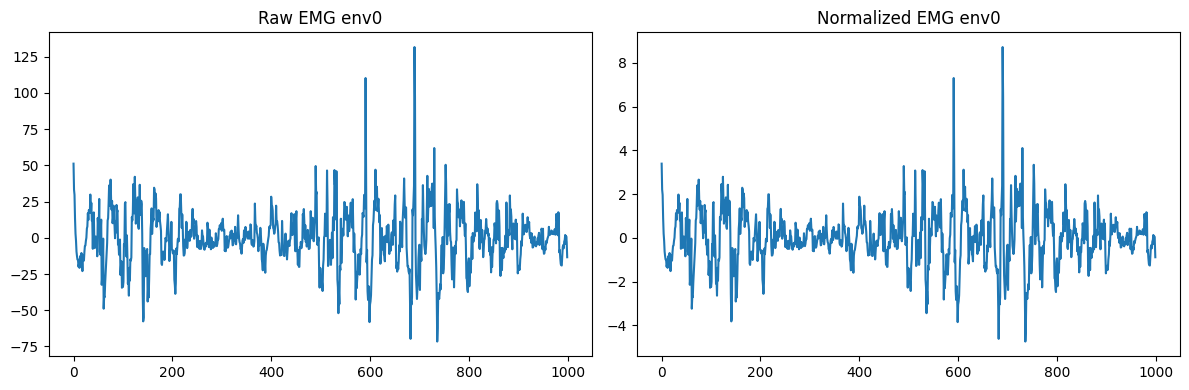

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Raw EMG env0")
plt.plot(X[:, 0][:1000])  # first 1000 samples
plt.subplot(1, 2, 2)
plt.title("Normalized EMG env0")
plt.plot(X_scaled[:, 0][:1000])
plt.tight_layout()
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

# Define neighbor relationships (1-indexed for readability)
neighbors = {
    1: [],          
    2: [3],         
    3: [2, 4],      
    4: [3]          
}

# Compute raw and env neighbor differences
for base in range(1, 5):  
    raw_base = f'raw{base-1}'
    env_base = f'env{base-1}'
    
    if not neighbors[base]:
        df_clean[f'raw_diff{base}'] = 0.0
        df_clean[f'env_diff{base}'] = 0.0
    else:
        raw_diffs = [df_clean[raw_base] - df_clean[f'raw{n-1}'] for n in neighbors[base]]
        env_diffs = [df_clean[env_base] - df_clean[f'env{n-1}'] for n in neighbors[base]]
        # Average if multiple neighbors
        df_clean[f'raw_diff{base}'] = sum(raw_diffs) / len(raw_diffs)
        df_clean[f'env_diff{base}'] = sum(env_diffs) / len(env_diffs)

additional_features = [f'raw_diff{i}' for i in range(1, 5)] + [f'env_diff{i}' for i in range(1, 5)]

print("\nAdded engineered features:")
print(additional_features)

sensor_columns = [
    'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3',
    *additional_features
]

X = df_clean[sensor_columns].values.astype(np.float32)

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Add normalized columns back to DataFrame
for i, col in enumerate(sensor_columns):
    df_clean[col + '_norm'] = X_scaled[:, i]

print(f"\nFinal numeric data shape: {df_clean.shape}")
print(f"Columns after feature engineering: {list(df_clean.columns)}")


Added engineered features:
['raw_diff1', 'raw_diff2', 'raw_diff3', 'raw_diff4', 'env_diff1', 'env_diff2', 'env_diff3', 'env_diff4']

Final numeric data shape: (125945, 41)
Columns after feature engineering: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label', 'raw_diff1', 'env_diff1', 'raw_diff2', 'env_diff2', 'raw_diff3', 'env_diff3', 'raw_diff4', 'env_diff4', 'env0_norm', 'raw0_norm', 'env1_norm', 'raw1_norm', 'env2_norm', 'raw2_norm', 'env3_norm', 'raw3_norm', 'raw_diff1_norm', 'raw_diff2_norm', 'raw_diff3_norm', 'raw_diff4_norm', 'env_diff1_norm', 'env_diff2_norm', 'env_diff3_norm', 'env_diff4_norm']


In [10]:
# Save scaler for inference
import joblib
joblib.dump(scaler_X, "scaler_inputs_lstm.pkl")
print(f"Scaler saved with {scaler_X.n_features_in_} features")

Scaler saved with 16 features


In [11]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-3
warmup_epochs = 5
max_epochs = 200
eta_min = 1e-6
window_size = 30
stride = 5
hidden_size = 128
num_layers = 3
dropout = 0.2

## Windows

In [12]:
import numpy as np

def create_windows(X, y, window_size=30, stride=5, pred_delay=0):
    """
    Convert continuous time-series into overlapping windows for sequence modeling.

    Args:
        X (ndarray): shape (n_samples, n_features)
        y (ndarray): shape (n_samples, n_targets)
        window_size (int): number of samples per window
        stride (int): hop size between windows
        pred_delay (int): how far ahead the label is predicted

    Returns:
        X_win: (n_windows, window_size, n_features)
        y_win: (n_windows, n_targets)
    """
    Xs, ys = [], []
    for i in range(0, len(X) - window_size - pred_delay, stride):
        Xs.append(X[i : i + window_size])
        ys.append(y[i + window_size + pred_delay - 1])
    return np.stack(Xs), np.stack(ys)


X_win, y_win = create_windows(X_scaled, y_scaled, window_size=window_size, stride=stride)
print(f"Windows: {X_win.shape}, Targets: {y_win.shape}")

Windows: (25183, 30, 16), Targets: (25183, 6)


In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X_win, dtype=torch.float32)
y_tensor = torch.tensor(y_win, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

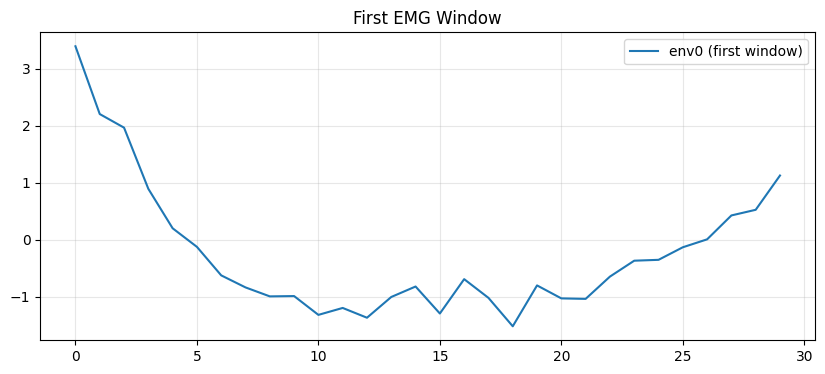

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(X_win[0, :, 0], label="env0 (first window)")
plt.title("First EMG Window")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Training

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create individual LSTM layers for skip connections
        self.lstm_layers = nn.ModuleList()
        for i in range(num_layers):
            input_size = n_inputs if i == 0 else hidden_size
            self.lstm_layers.append(
                nn.LSTM(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=1,
                    batch_first=True
                )
            )
        
        # Dropout layers between LSTM layers
        if num_layers > 1:
            self.dropout = nn.Dropout(dropout)
        
        # Projection layer to match dimensions for skip connections
        self.input_projection = nn.Linear(n_inputs, hidden_size) if n_inputs != hidden_size else None
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, n_outputs)
        
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        
        # Store skip connections
        skip_connections = []
        
        # First LSTM layer
        out, _ = self.lstm_layers[0](x)
        
        # Project input to match hidden_size for skip connection
        if self.input_projection is not None:
            x_projected = self.input_projection(x)
        else:
            x_projected = x
        
        skip_connections.append(x_projected)
        
        # Remaining LSTM layers with skip connections
        for i in range(1, self.num_layers):
            if self.num_layers > 1:
                out = self.dropout(out)
            
            # Add skip connection from previous layer
            out = out + skip_connections[-1]
            
            # Pass through LSTM layer
            out, _ = self.lstm_layers[i](out)
            
            # Store current output for next skip connection
            skip_connections.append(out)
        
        # Take the last time step output
        last_output = out[:, -1, :]
        
        # Pass through fully connected layer
        output = self.fc(last_output)
        return output

In [16]:
X_tensor = torch.tensor(X_win, dtype=torch.float32)
y_tensor = torch.tensor(y_win, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

# Split into train/test
n_train = int(len(dataset) * 0.8)
train_set, test_set = torch.utils.data.random_split(dataset, [n_train, len(dataset) - n_train])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 630, Test batches: 158


In [17]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class AdaptiveCosineAnnealingWarmupLR(_LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, eta_min=0, last_epoch=-1):
        """
        Args:
            optimizer (Optimizer): Wrapped optimizer.
            warmup_epochs (int): Number of warmup epochs.
            max_epochs (int): Total number of epochs.
            eta_min (float): Minimum learning rate. Default: 0.
            last_epoch (int): The index of the last epoch. Default: -1.
        """
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.eta_min = eta_min
        super(AdaptiveCosineAnnealingWarmupLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            # Warmup phase
            return [
                base_lr * (self.last_epoch + 1) / self.warmup_epochs
                for base_lr in self.base_lrs
            ]
        else:
            # Cosine annealing phase
            return [
                self.eta_min + (base_lr - self.eta_min) * 
                (1 + math.cos(math.pi * (self.last_epoch - self.warmup_epochs) / 
                              (self.max_epochs - self.warmup_epochs))) / 2
                for base_lr in self.base_lrs
            ]

In [18]:
from tqdm import trange, tqdm

n_inputs = X_tensor.shape[2]
n_outputs = y_tensor.shape[1]

model = LSTMModel(n_inputs, n_outputs, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = AdaptiveCosineAnnealingWarmupLR(optimizer, warmup_epochs=warmup_epochs, max_epochs=max_epochs, eta_min=eta_min)
criterion = nn.MSELoss()

train_losses, test_losses = [], []
learning_rates = []  # To store learning rates
best_loss = float('inf')
patience = 30  # Number of epochs to wait for improvement
patience_counter = 0

for epoch in range(max_epochs):
    # ---- Training ----
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    
    # Step the scheduler and log the learning rate
    scheduler.step()
    learning_rates.append(optimizer.param_groups[0]['lr'])

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    tqdm.write(f"Epoch {epoch+1:3d}/{max_epochs} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f} | LR: {learning_rates[-1]:.6e}")

    # ---- Early Stopping ----
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch   1/200 | Train Loss: 0.098864 | Test Loss: 0.072640 | LR: 4.000000e-04
Epoch   2/200 | Train Loss: 0.067842 | Test Loss: 0.063885 | LR: 6.000000e-04
Epoch   2/200 | Train Loss: 0.067842 | Test Loss: 0.063885 | LR: 6.000000e-04
Epoch   3/200 | Train Loss: 0.063286 | Test Loss: 0.061710 | LR: 8.000000e-04
Epoch   3/200 | Train Loss: 0.063286 | Test Loss: 0.061710 | LR: 8.000000e-04
Epoch   4/200 | Train Loss: 0.059864 | Test Loss: 0.057401 | LR: 1.000000e-03
Epoch   4/200 | Train Loss: 0.059864 | Test Loss: 0.057401 | LR: 1.000000e-03
Epoch   5/200 | Train Loss: 0.056074 | Test Loss: 0.057188 | LR: 1.000000e-03
Epoch   5/200 | Train Loss: 0.056074 | Test Loss: 0.057188 | LR: 1.000000e-03
Epoch   6/200 | Train Loss: 0.051938 | Test Loss: 0.054133 | LR: 9.999352e-04
Epoch   6/200 | Train Loss: 0.051938 | Test Loss: 0.054133 | LR: 9.999352e-04
Epoch   7/200 | Train Loss: 0.047477 | Test Loss: 0.051224 | LR: 9.997407e-04
Epoch   7/200 | Train Loss: 0.047477 | Test Loss: 0.051224 | LR:

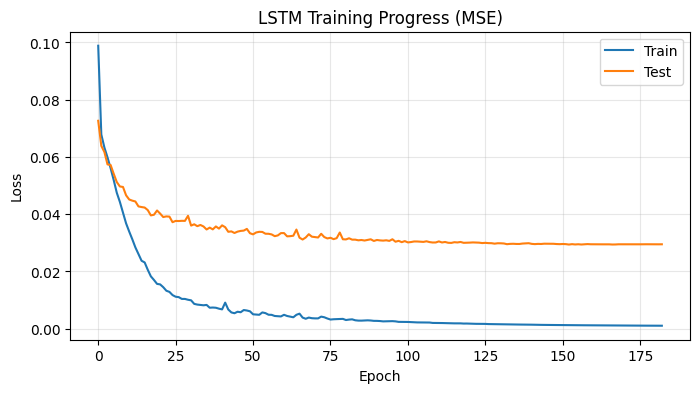

In [19]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.title("LSTM Training Progress (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

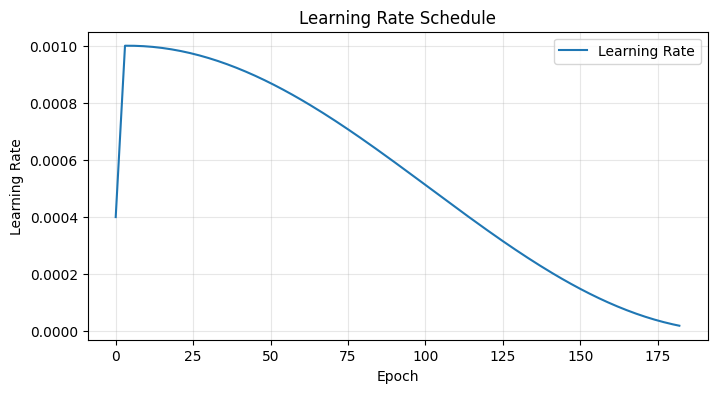

In [20]:
# Plot the learning rate schedule
plt.figure(figsize=(8, 4))
plt.plot(learning_rates, label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [21]:
# Save the final model
torch.save(model.state_dict(), 'lstm_model_final.pth')
print("Model saved to lstm_model_final.pth")

# Save complete model with architecture
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'learning_rates': learning_rates,
    'hyperparameters': {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'warmup_epochs': warmup_epochs,
        'max_epochs': max_epochs,
        'eta_min': eta_min,
        'window_size': window_size,
        'stride': stride,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'lstm_model_complete.pth')
print("Complete model checkpoint saved to lstm_model_complete.pth")

Model saved to lstm_model_final.pth
Complete model checkpoint saved to lstm_model_complete.pth


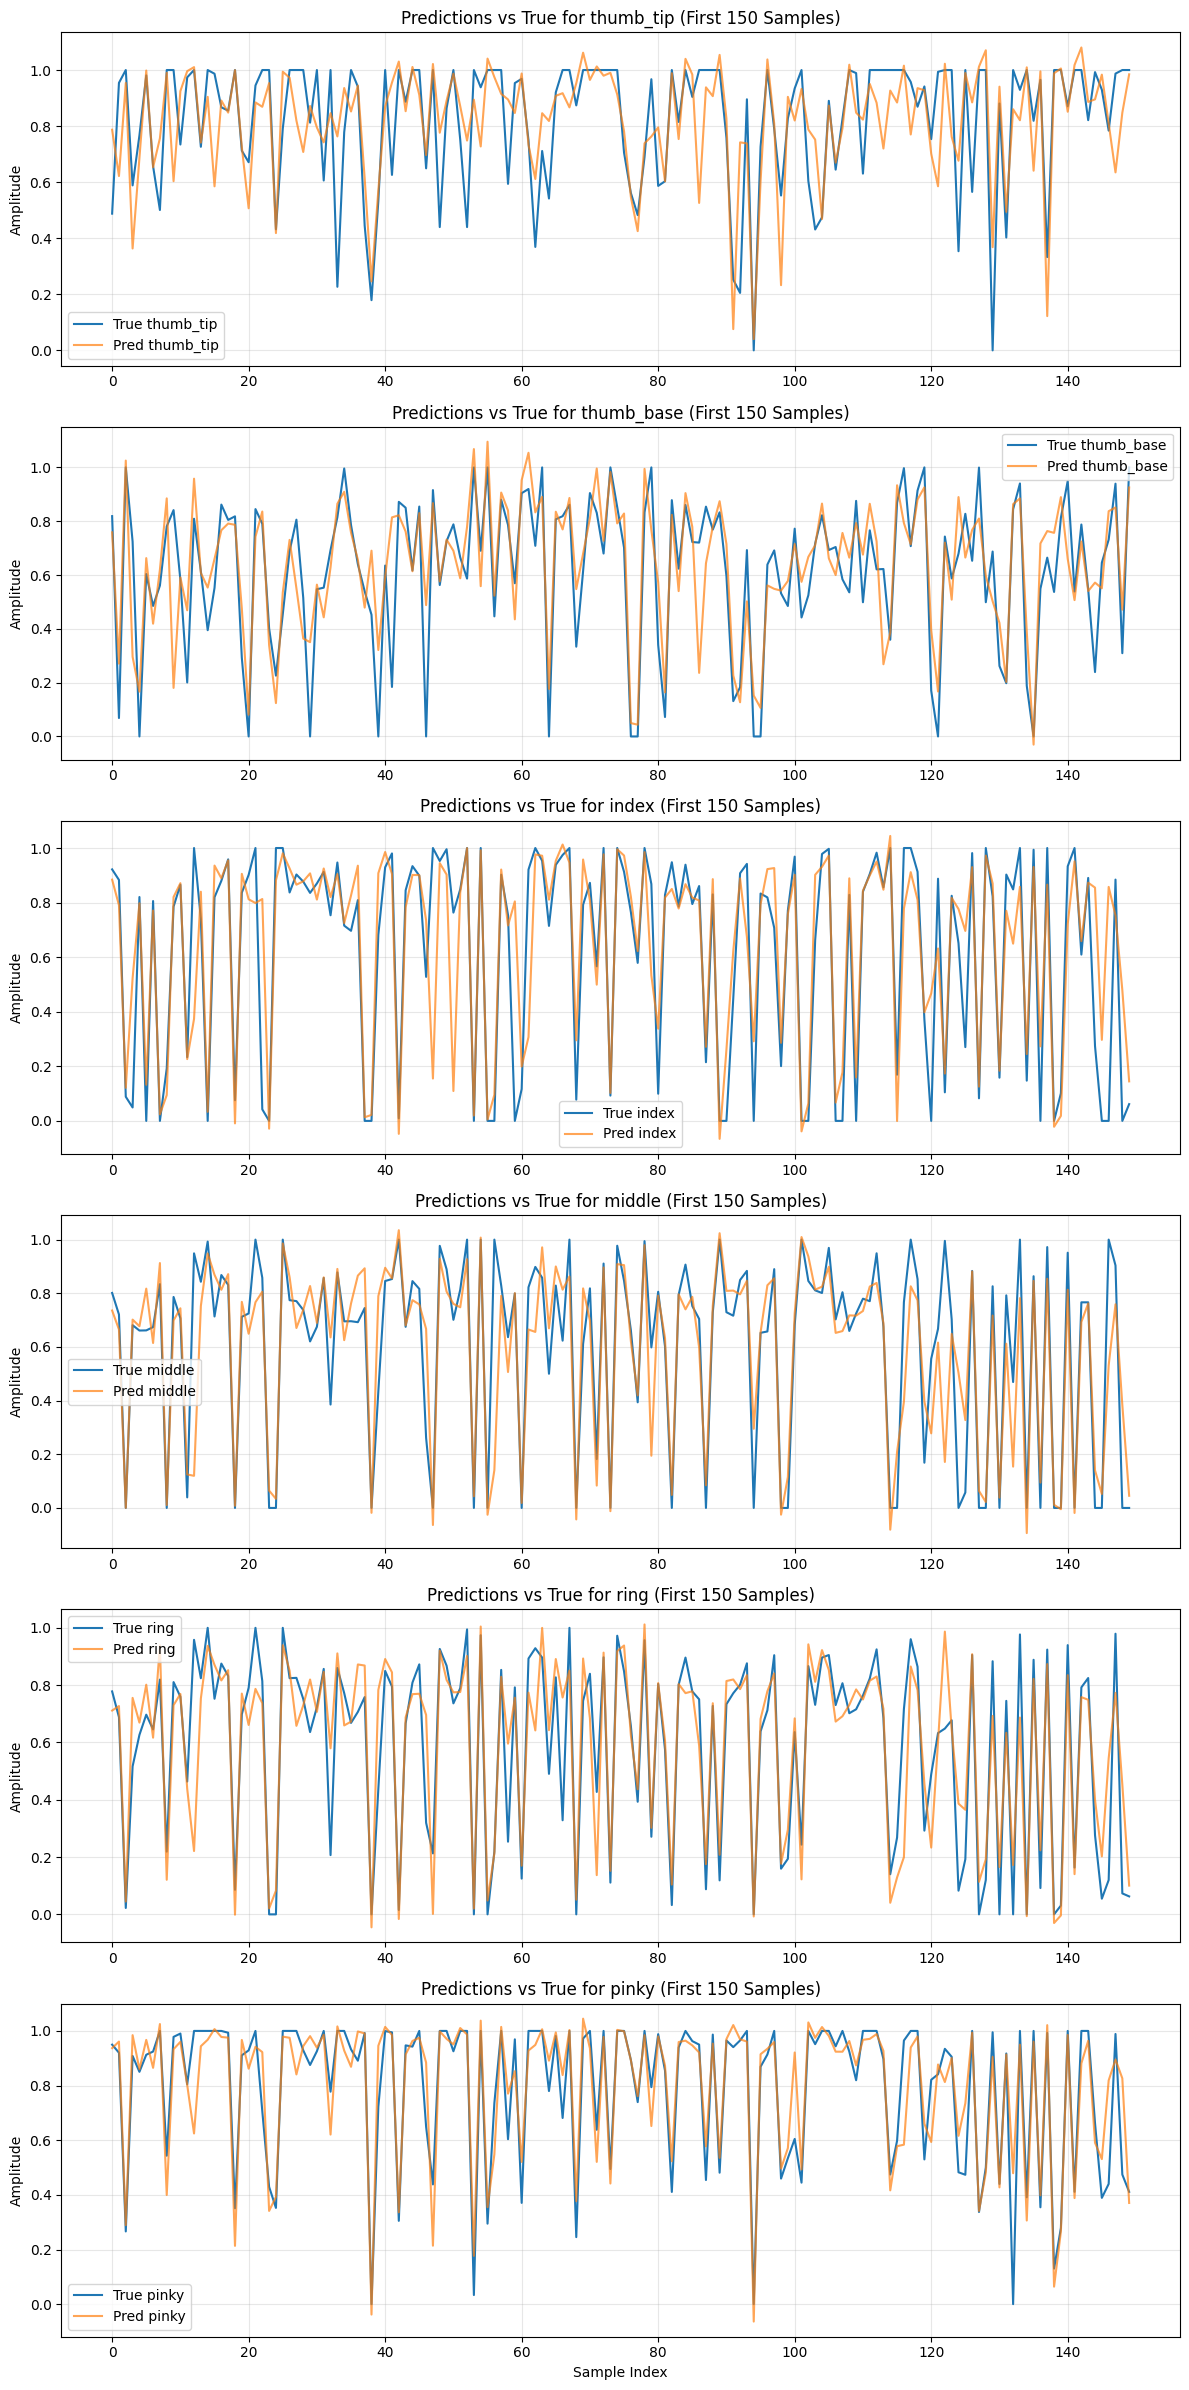

In [22]:
model.eval()
y_true = []
y_pred = []

# Collect predictions and ground truth for multiple batches
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).cpu().numpy()
        y_true.append(yb.cpu().numpy())
        y_pred.append(preds)

# Concatenate all batches
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

finger_names = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

# Plot 200 data points, one figure per finger
plt.figure(figsize=(12, len(finger_names) * 4))  # Adjust height for better spacing
for i, name in enumerate(finger_names):
    plt.subplot(len(finger_names), 1, i + 1)  # One row per finger
    plt.plot(y_true[:150, i], label=f"True {name}")
    plt.plot(y_pred[:150, i], label=f"Pred {name}", alpha=0.7)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f"Predictions vs True for {name} (First 150 Samples)", fontsize=12)
    plt.ylabel("Amplitude")
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Overall Test Metrics:")
print(f"  MSE: {mse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  R²:  {r2:.4f}")


finger_names = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

print("\nPer-finger metrics:")
for i, name in enumerate(finger_names):
    mse_i = mean_squared_error(y_true[:, i], y_pred[:, i])
    mae_i = mean_absolute_error(y_true[:, i], y_pred[:, i])
    r2_i = r2_score(y_true[:, i], y_pred[:, i])
    print(f"  {name:<12} | MSE: {mse_i:.6f} | MAE: {mae_i:.6f} | R²: {r2_i:.4f}")

Overall Test Metrics:
  MSE: 0.029493
  MAE: 0.110741
  R²:  0.6731

Per-finger metrics:
  thumb_tip    | MSE: 0.040082 | MAE: 0.136130 | R²: 0.3519
  thumb_base   | MSE: 0.026797 | MAE: 0.117323 | R²: 0.6838
  index        | MSE: 0.037720 | MAE: 0.120282 | R²: 0.7144
  middle       | MSE: 0.030029 | MAE: 0.105491 | R²: 0.7621
  ring         | MSE: 0.025845 | MAE: 0.105752 | R²: 0.7609
  pinky        | MSE: 0.016483 | MAE: 0.079470 | R²: 0.7655
